## Import CIFAR-10 and remove center for inplainting

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.optimizers import Adam

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dense, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input

## Mask and Remove Mask

In [4]:
# Normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Function to remove the center of CIFAR-10 images
def get_mask(imgs, mask_size):
    mask = imgs.copy()
    center_x, center_y = imgs.shape[1] // 2, imgs.shape[2] // 2
    mask = mask[:, center_x-mask_size:center_x+mask_size, center_y-mask_size:center_y+mask_size, :]
    return mask
# Function to remove the center of CIFAR-10 images
def remove_center(imgs, mask_size):
    masked_imgs = imgs.copy()
    center_x, center_y = imgs.shape[1] // 2, imgs.shape[2] // 2
    masked_imgs[:, center_x-mask_size:center_x+mask_size, center_y-mask_size:center_y+mask_size, :] = 0
    return masked_imgs

# Apply masking to training and test images
x_train_removed = remove_center(x_train, 8)
x_test_removed = remove_center(x_test, 8)
x_train_mask = get_mask(x_train, 8)
x_test_mask = get_mask(x_test, 8)

print(x_train[0].shape)
print(x_train_removed[0].shape)
print(x_train_mask[0].shape)

(32, 32, 3)
(32, 32, 3)
(16, 16, 3)


In [6]:
def insert_generated_center(original_images, generated_centers, center_size=16):
   
    # Calculate start and end indices for center insertion
    start = (original_images.shape[1] - center_size) // 2
    end = start + center_size

    # Make a copy of the original images to avoid modifying the original array
    images_with_centers = np.copy(original_images)

    # Replace the center of each image with the generated patch
    images_with_centers[:, start:end, start:end, :] = generated_centers

    return images_with_centers

In [7]:
def mse(imageA, imageB):
    # Ensure the images are floating point values
    imageA = imageA.astype('float32')
    imageB = imageB.astype('float32')
    # Compute the mean squared error between the two images
    err = np.mean((imageA - imageB) ** 2)
    return err


## Visualize the Graph

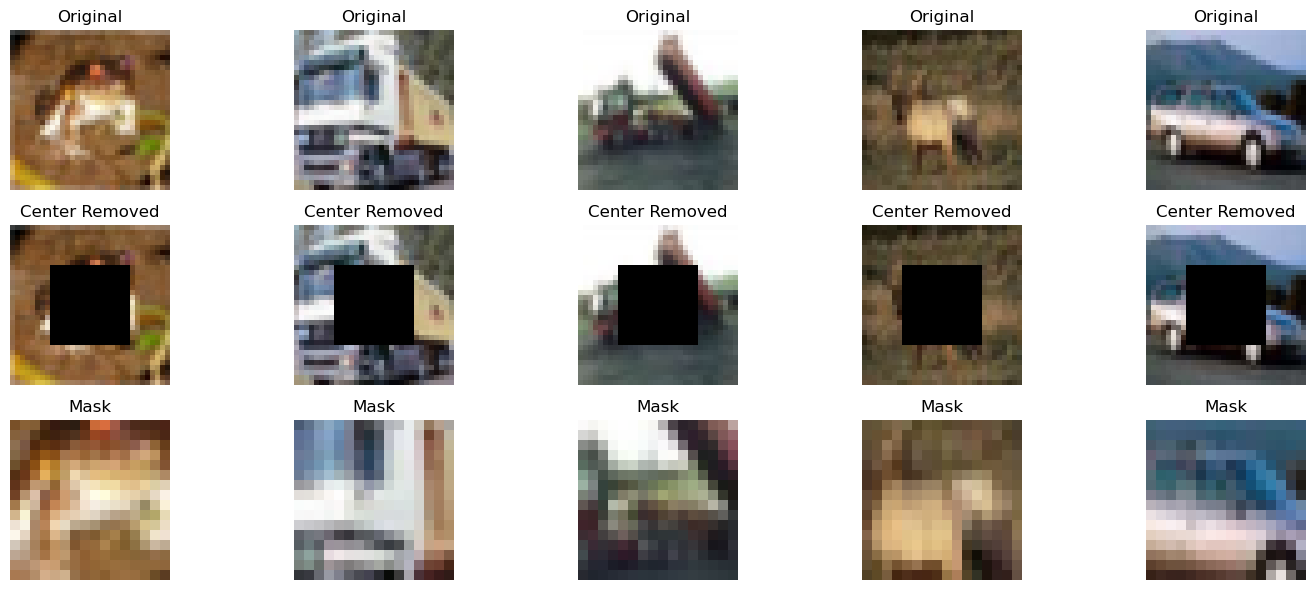

In [6]:
fig, axs = plt.subplots(3, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(x_train[i])
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(x_train_removed[i])
    axs[1, i].set_title('Center Removed')
    axs[1, i].axis('off')

    axs[2, i].imshow(x_train_mask[i])
    axs[2, i].set_title('Mask')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

Visualize the orginal picture and removed picture

## Encoder Decoder

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dense, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input

def build_encoder_decoder(input_shape=(32, 32, 3), output_shape=(16, 16, 3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Ensuring we have a suitable feature map size

    # Fully Connected layer simulation 
    x = Flatten()(encoded)
    x = Dense(4096, activation='relu')(x)  
    x = Reshape((4, 4, 256))(x) 

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # Adjust to target output size
    decoded = Conv2D(output_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=input_img, outputs=decoded)
    return model

encoder_decoder = build_encoder_decoder()
encoder_decoder.compile(optimizer='adam', loss='mse')
encoder_decoder.summary()


2024-03-22 19:13:30.326121: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-22 19:13:30.326181: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-22 19:13:30.326199: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-22 19:13:30.326263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 19:13:30.326282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512   

## Train the model

In [16]:
encoder_decoder.fit(x_train_removed, x_train_mask,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_removed, x_test_mask))

Epoch 1/30
391/391 [==============================] - 28s 67ms/step - loss: 0.0314 - val_loss: 0.1086
Epoch 2/30
391/391 [==============================] - 23s 57ms/step - loss: 0.0261 - val_loss: 0.0267
Epoch 3/30
391/391 [==============================] - 23s 60ms/step - loss: 0.0249 - val_loss: 0.0265
Epoch 4/30
391/391 [==============================] - 24s 60ms/step - loss: 0.0242 - val_loss: 0.0263
Epoch 5/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0234 - val_loss: 0.0276
Epoch 6/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0228 - val_loss: 0.0257
Epoch 7/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0220 - val_loss: 0.0253
Epoch 8/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0211 - val_loss: 0.0254
Epoch 9/30
391/391 [==============================] - 23s 60ms/step - loss: 0.0202 - val_loss: 0.0255
Epoch 10/30
391/391 [==============================] - 23s 60ms/step - loss: 0.019

In [17]:
generated_images = encoder_decoder.predict(x_test_removed[:])

image_with_center = insert_generated_center(x_test_removed[:], generated_images)

313/313 [==============================] - 3s 10ms/step


##  First 20 image in CiFar 10

313/313 [==============================] - 3s 10ms/step


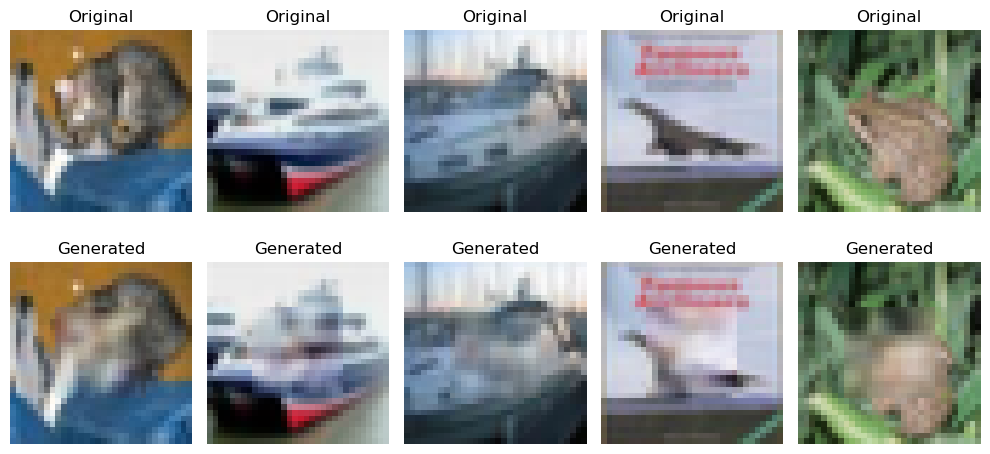

Average MSE: 0.0074791633524000645


In [68]:
generated_images = encoder_decoder.predict(x_test_removed[:])

image_with_center = insert_generated_center(x_test_removed[:], generated_images)

# Select a few images to display
num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_truck_images = len(x_test)
mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')

## tranning set

1563/1563 [==============================] - 16s 10ms/step


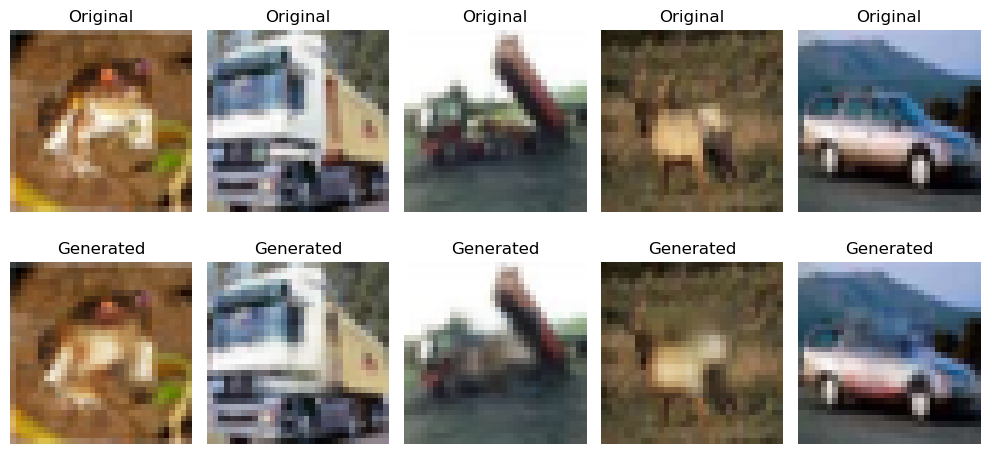

Average MSE: 0.0013751639053225517


In [65]:
generated_images = encoder_decoder.predict(x_train_removed[:])

image_with_center = insert_generated_center(x_train_removed[:], generated_images)

num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_train[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_images = len(x_train)
mse_values = []
for i in range(num_images):
    mse_values.append(mse(x_train[i], image_with_center[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')

## One category Image and its MSE

In [21]:
num_truck_images = len(x_test)
mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
print(len(mse_values))
print(f'Average MSE: {average_mse}')

10000
Average MSE: 0.007338516414165497


1000
Average MSE: 0.0072539146058261395


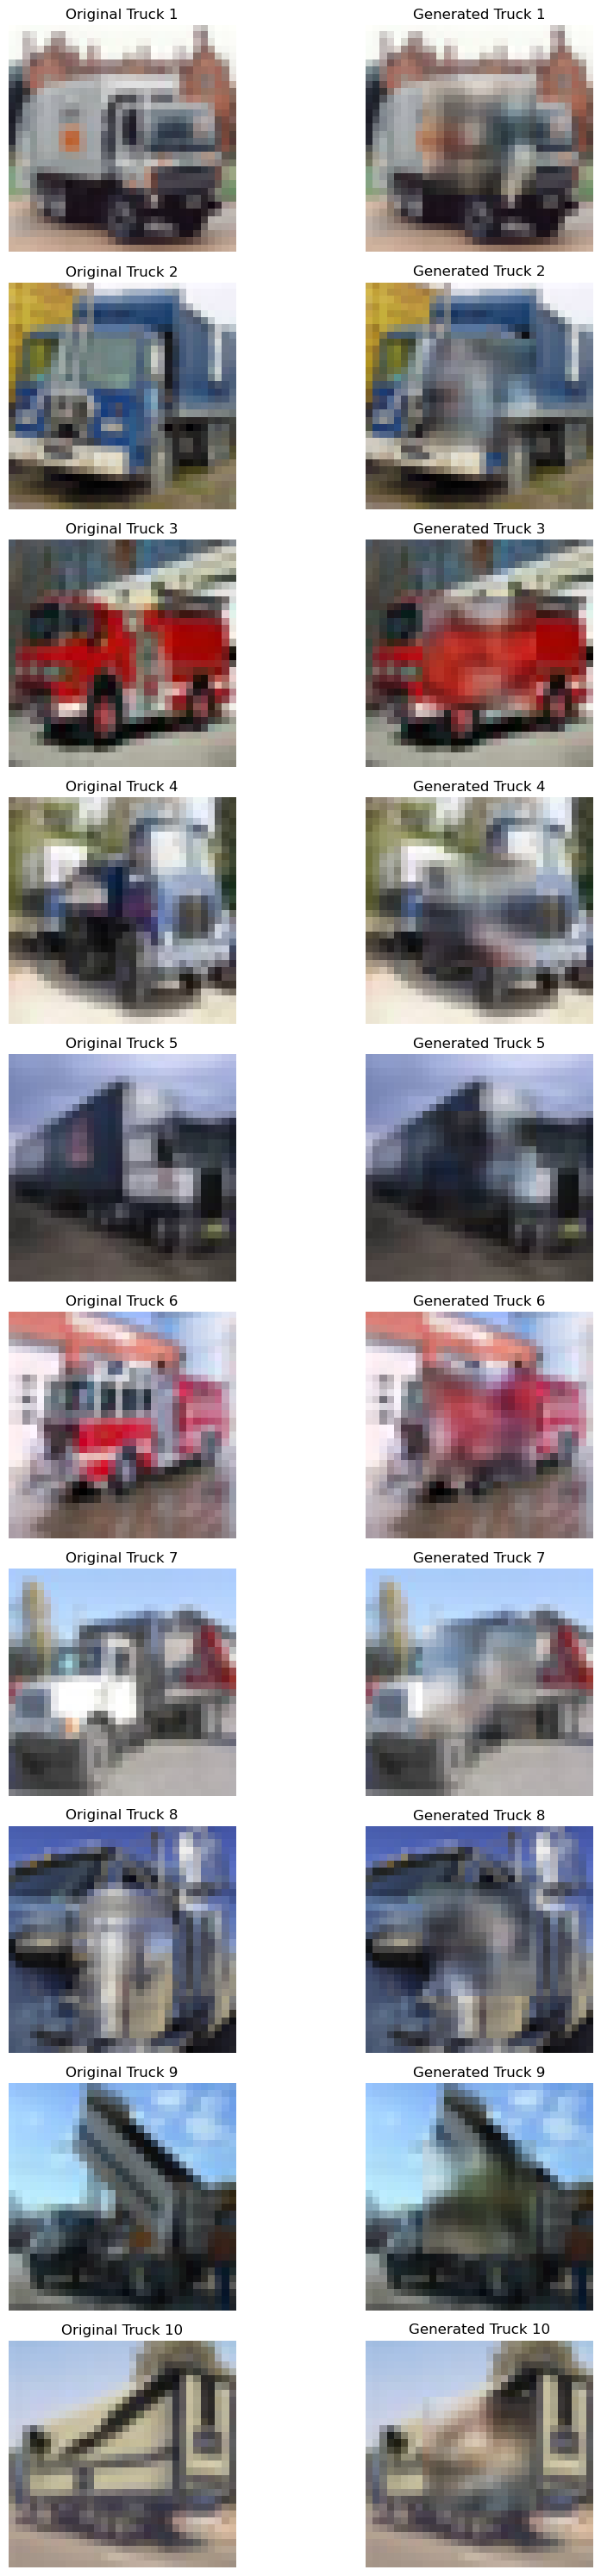

In [20]:
category = 9

y_test_flattened = y_test.flatten()    # Flatten y_test to make it a 1D array

# Find indices where y_test is 9 (assuming 9 corresponds to 'truck')
truck_indices = [i for i, label in enumerate(y_test_flattened) if label == category]

# Display up to the first 10 truck images
num_truck_images = len(truck_indices)


mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
print(len(mse_values))
print(f'Average MSE: {average_mse}')


num_truck_images = 10
fig, axes = plt.subplots(num_truck_images, 2, figsize=(10, 3 * num_truck_images))
for i in range(num_truck_images):
    truck_index = truck_indices[i]

    # Display original image
    ax = axes[i, 0]
    ax.imshow(x_test[truck_index])
    ax.set_title(f"Original Truck {i+1}")
    ax.axis("off")

    # Display generated (reconstructed) image
    ax = axes[i, 1]
    ax.imshow(image_with_center[truck_index])
    ax.set_title(f"Generated Truck {i+1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Mask lower right corner

In [14]:
def insert_generated_corner(original_images, generated_corners, corner_size=16):
    # Calculate start indices for the rows (height) and columns (width)
    start_row = original_images.shape[1] - corner_size
    start_col = original_images.shape[2] - corner_size
    
    # Ensure the indices are within the image dimensions
    if start_row < 0: start_row = 0
    if start_col < 0: start_col = 0
    
    # Make a copy of the original images to avoid modifying the original array
    images_with_corners = np.copy(original_images)

    # Replace the lower right corner of each image with the generated patch
    images_with_corners[:, start_row:, start_col:, :] = generated_corners

    return images_with_corners

## Mask upper left

In [36]:
def remove_and_return_upper_left_corner(imgs, mask_size):
    masked_imgs = imgs.copy()
    
    # The starting indices for the upper left corner are both 0
    start_row = 0
    start_col = 0
    
    # Extract the upper left corner
    upper_left_corners = imgs[:, start_row:start_row+mask_size, start_col:start_col+mask_size, :].copy()
    
    # Set the upper left corner to zero in the masked images
    masked_imgs[:, start_row:start_row+mask_size, start_col:start_col+mask_size, :] = 0
    
    return masked_imgs, upper_left_corners

# Function usage
mask_size = 16  # for example, to remove a 16x16 patch from the upper left corner
x_train_masked, x_train_corners = remove_and_return_upper_left_corner(x_train, mask_size)
x_test_masked, x_test_corners = remove_and_return_upper_left_corner(x_test, mask_size)

# Shapes of the original, masked, and corner images
print(x_train[0].shape)
print(x_train_masked[0].shape)
print(x_train_corners[0].shape)

(32, 32, 3)
(32, 32, 3)
(16, 16, 3)


In [37]:
def insert_generated_upper_left_corner(original_images, generated_corners, corner_size=16):
    # The start indices for the upper left corner are both 0
    start_row = 0
    start_col = 0
    
    # Make a copy of the original images to avoid modifying the original array
    images_with_upper_left_corners = np.copy(original_images)

    # Replace the upper left corner of each image with the generated patch
    # Ensure that the generated_corners array matches the dimensions where it's being inserted
    images_with_upper_left_corners[:, start_row:start_row+corner_size, start_col:start_col+corner_size, :] = generated_corners

    return images_with_upper_left_corners

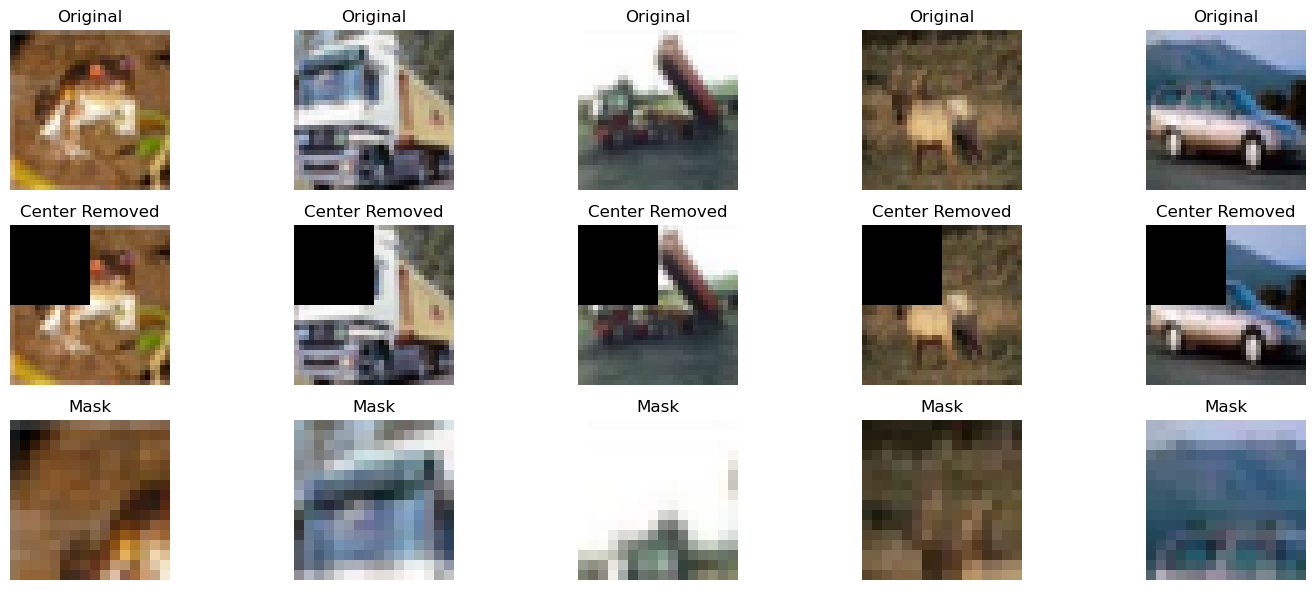

In [38]:
fig, axs = plt.subplots(3, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(x_train[i])
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(x_train_masked[i])
    axs[1, i].set_title('Center Removed')
    axs[1, i].axis('off')

    axs[2, i].imshow(x_train_corners[i])
    axs[2, i].set_title('Mask')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

encoder_decoder_2 = build_encoder_decoder()
# Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitors the validation loss
#     patience=5,         # Number of epochs with no improvement after which training will be stopped
#     verbose=1,          # To log when training is stopped
#     restore_best_weights=True  # Restores model weights from the epoch with the minimum validation loss
# )

# Compile your model
encoder_decoder_2.compile(optimizer='adam', loss='mse')

# Fit the model with the early stopping callback
history = encoder_decoder_2.fit(
    x_train_masked, x_train_corners,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_masked, x_test_corners),
#     callbacks=[early_stopping]  # Add early stopping callback here
)


Epoch 1/30
391/391 [==============================] - 26s 65ms/step - loss: 0.0300 - val_loss: 0.1033
Epoch 2/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0257 - val_loss: 0.0281
Epoch 3/30
391/391 [==============================] - 23s 60ms/step - loss: 0.0246 - val_loss: 0.0269
Epoch 4/30
391/391 [==============================] - 24s 61ms/step - loss: 0.0239 - val_loss: 0.0268
Epoch 5/30
391/391 [==============================] - 24s 62ms/step - loss: 0.0232 - val_loss: 0.0260
Epoch 6/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0224 - val_loss: 0.0261
Epoch 7/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0215 - val_loss: 0.0249
Epoch 8/30
391/391 [==============================] - 23s 58ms/step - loss: 0.0204 - val_loss: 0.0254
Epoch 9/30
391/391 [==============================] - 23s 59ms/step - loss: 0.0192 - val_loss: 0.0251
Epoch 10/30
391/391 [==============================] - 23s 58ms/step - loss: 0.018

313/313 [==============================] - 3s 10ms/step


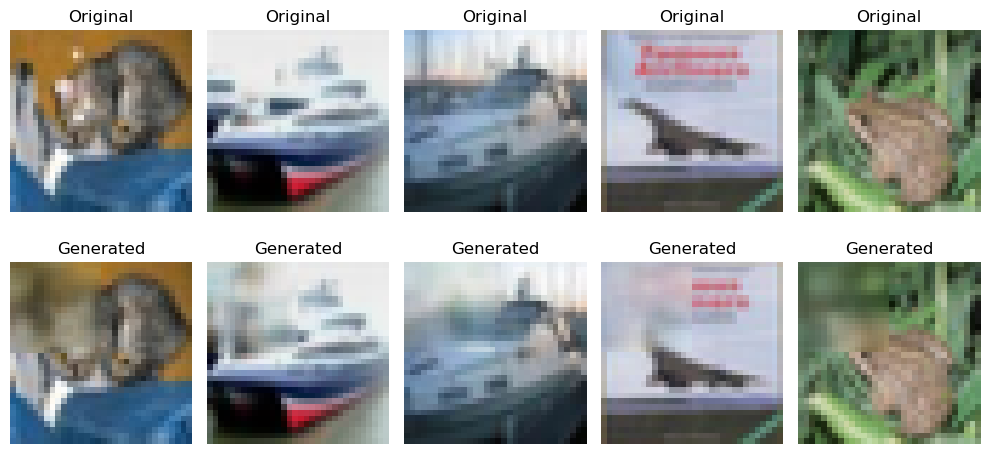

Average MSE: 0.007227609399706125


In [70]:
generated_images = encoder_decoder_2.predict(x_test_masked[:])

image_with_center = insert_generated_upper_left_corner(x_test_masked[:], generated_images)

num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_truck_images = len(x_test)
mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')